# Eight Queens

## Introduction

This notebook implements multiple genetic algorithms to solve the eight queens problems and some of its extensions.

## Contents

- Eight Queens State Logic
- Basic Implementation
- Advanced Implementation
    - Permutation based representation
    - Viral infection
- Extensions
    - Hyperparameter tuning
    - Algorithmic time complexity analysis
    - n-queen generalisation

## Python Dependencies

The following external dependencies are required:

numpy==1.26.4

matplotlib>=3.8.0,<4.0.0

pandas>=2.1.0,<3.0.0

seaborn>=0.13.0

In [84]:
# Standard library
import time
import heapq
import random
import itertools
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, as_completed

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

plt.rcParams["font.family"] = "DejaVu Sans"

# Eight Queens State Logic

Updated from that provided in course materials. Cost is made more efficient by reducing objects created and iterations made per individual, and unused methods are removed.

In [ ]:
class UpdatedEightQueensState:
    """
    This class represents a board in the eight queens puzzle
    """
    def __init__(self, state=None, n=8):
        if state is None:
            self.n = n
            state = np.random.randint(0, n, n)
        else:
            self.n = len(state)
        self.state = state.copy() # Copy to avoid unexpected data structure mutation behaviour

    def cost(self):
        """
        !!!! UPDATED !!!
        
        Number of attacking pairs (row or diagonal).
        state[col] = row
        """
        c = 0
        n = len(self.state)
        for i in range(n):
            for j in range(i + 1, n):
                if self.state[i] == self.state[j]:
                    c += 1
                if abs(self.state[i] - self.state[j]) == (j - i):
                    c += 1
        return c

    def __str__(self):
        if self.cost() == 0:
            return f"Goal state! {self.state}"
        else:
            return f"{self.state} cost {self.cost()}"

# Basic Implementation

The basic implementation includes:
- Elitism
- Reproduction by crossover
- Mutation

In [75]:
class BaseEightQueensGeneticAlgorithm():
    """
    Basic genetic algorithm implementation.
    """
    def __init__(self, population, elitism_rate=0.25, mutation_rate=0.25,
                 num_queens=8, early_stopping=False, max_generations=500, seed=1):
        
        self.population = population
        self.elitism_rate = elitism_rate
        self.mutation_rate = mutation_rate
        self.num_queens = num_queens

        self.population_size = len(population)
        self.iterations = 0
        self.start = 0
        self.end = 0
        self.mutation_counter = 0

        self.min_weights = []
        self.max_weights = []

        self.early_stopping = early_stopping
        self.max_generations = max_generations

        self.rng = np.random.default_rng()
        random.seed(seed)
        np.random.seed(seed)

    def solve(self):
        self.start = time.time()
        result = self.search(self.mutate)
        self.end = time.time()
        return result
    
    def search(self, func):
        while True:
            if self.early_stopping and self.iterations >= self.max_generations:
                break

            self.iterations += 1

            # Calculate costs
            costs = [ind.cost() for ind in self.population]
            best_cost = min(costs)
            worst_cost = max(costs)
            
            self.min_weights.append(best_cost)
            self.max_weights.append(worst_cost)

            # Check if solution found
            if best_cost == 0:
                best_idx = costs.index(0)
                best_ind = self.population[best_idx]
                print(f"\nFound solution {best_ind.state}")
                return best_ind

            # Elitism
            elite, weights_rest = self.get_elite()

            # Produce children so that elite + children = population_size
            target_children = self.population_size - len(elite)
            population2 = []

            while len(population2) < target_children:
                parent1, parent2 = self.roulette_selection(weights_rest, 2)
                for child in self.reproduce(parent1, parent2):
                    population2.append(child)
                    if len(population2) >= target_children:
                        break

            # Mutate children
            population2 = func(population2)

            # New population
            self.population = elite + population2

        # If we get here, no solution found within max_generations
        final_costs = [ind.cost() for ind in self.population]
        best_ind = min(zip(final_costs, self.population), key=lambda t: t[0])[1]
        print(f"\nCould not find solution {best_ind.state}")
        return best_ind

    def get_elite(self):
        """
        Gets self.elitism_rate portion of the population with the highest fitness scores and recalculates weights.
        """
        weights = self.fitness()
        sorted_population = [x for _, x in sorted(zip(weights, self.population), key=lambda t: t[0], reverse=True)]
        index = int(len(sorted_population) * self.elitism_rate)
        self.population, elite = sorted_population[index:], sorted_population[:index]
        weights = self.fitness()
        return (elite, weights)

    def get_fitness_squared(self, individual):
        """
        Calculates a fitness score for an individual.
        """
        return ((self.num_queens * (self.num_queens - 1)) - individual.cost()) ** 2

    def fitness(self):
        """
        Calculates a fitness score for each individual in the population.
        Can be used to drive elitism and probabilistic sampling selection methods.
        """
        fitness_scores = [self.get_fitness_squared(individual) for individual in self.population]
        total_fitness = sum(fitness_scores)
        if total_fitness == 0:
            weights = [1.0 / len(self.population)] * len(self.population)
        else:
            weights = [f / total_fitness for f in fitness_scores]
        return weights

    def roulette_selection(self, weights, size):
        rng = np.random.default_rng()
        return rng.choice(self.population, size=size, replace=False, p=weights)
        
    def reproduce(self, parent1, parent2):
        """
        Simple reproduction algorithm that takes some segment of one parent and swaps it with the other parent, and vice versa.
        """
        c = random.randrange(0, self.num_queens, 1)
        return (UpdatedEightQueensState(state=parent1.state[0:c] + parent2.state[c:self.num_queens]),
                UpdatedEightQueensState(state=parent2.state[0:c] + parent1.state[c:self.num_queens]))

    def mutate(self, population):
        """
        Mutate by changing a random row value.
        """
        population2 = []
        for i in range(len(population)):
            if random.random() > self.mutation_rate:
                population2.append(population[i])
                continue
            
            self.mutation_counter += 1
            individual = population[i]
            col = random.randrange(0, self.num_queens, 1)
            s = individual.state
            s[col] = random.randrange(0, self.num_queens, 1)
            population2.append(UpdatedEightQueensState(state=s))
        return population2

    def get_time_elapsed(self):
        if self.start and self.end:
            return self.end - self.start
        return 0
    
    @staticmethod
    def build_individual(n):
        individual = [random.randrange(0, n, 1) for _ in range(0, n)]
        return UpdatedEightQueensState(state=individual)

The below code executes a genetic algorithm search for the 8-queens problem.

In [76]:
population_size = 100
num_queens = 8
population = [BaseEightQueensGeneticAlgorithm.build_individual(num_queens) for _ in range(0, population_size)]
solver = BaseEightQueensGeneticAlgorithm(population=population, num_queens=num_queens)
solution = solver.solve()

print()
print(f"Took '{solver.get_time_elapsed()}' seconds")
print(f"Number of iterations: '{solver.iterations}'")
print(f"Number of mutations: '{solver.mutation_counter}'")
print(solution.state)


Found solution [4, 2, 0, 5, 7, 1, 3, 6]

Took '2.3987832069396973' seconds
Number of iterations: '782'
Number of mutations: '14685'
[4, 2, 0, 5, 7, 1, 3, 6]


### Basic Implementation Visualisation

The solution is visualised on a graph styled to look like a chess board.

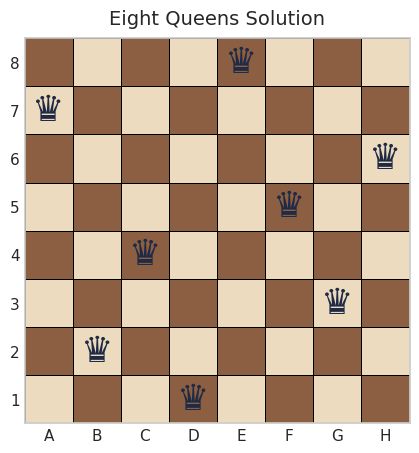

Took '1.725632905960083' seconds
Iterations 548
Mutations 10216


In [30]:
def plot_queens(state, title="Eight Queens Solution", width=5, height=5):
    n = len(state)
    light = "#EDDBBF"
    dark  = "#8C5E42"

    board = (np.add.outer(np.arange(n), np.arange(n)) % 2).astype(int)
    cmap = ListedColormap([light, dark])

    _, ax = plt.subplots(figsize=(width, height))

    edges = np.arange(-0.5, n + 0.5, 1)
    X, Y = np.meshgrid(edges, edges)

    ax.pcolormesh(X, Y, board.T, cmap=cmap, shading="flat", edgecolors="black", linewidth=0.6, antialiased=False)
    ax.set_aspect("equal")
    ax.set_xlim(-0.5, n - 0.5)
    ax.set_ylim(-0.5, n - 0.5)

    ax.set_xticks(range(n)); 
    ax.set_yticks(range(n))
    ax.set_xticklabels([chr(ord("A") + i) for i in range(n)], fontsize=11)
    ax.set_yticklabels(range(1, n + 1), fontsize=11)
    ax.tick_params(length=0)

    for col, row in enumerate(state):
        ax.text(col, row, "♛", ha="center", va="center", fontsize=26, color="#1f2a44")

    ax.set_title(title, pad=10, fontsize=14)
    plt.show()

plot_queens(solution.state)
print(f"Took '{solver.get_time_elapsed()}' seconds")
print(f"Iterations {solver.iterations}")
print(f"Mutations {solver.mutation_counter}")

### Basic Implementation Insights

The below chart displays minimum and maximum cost for the base algorithm, where cost is the number of attacking pairs of queens. No clear trend for either min or max cost shows that it would be difficult to predict the convergence of genetic algorithms.

- Min fitness more variable
- Little change from initial values to final, implying a fitness function that emphasises gaps more might lead to a faster algorithm

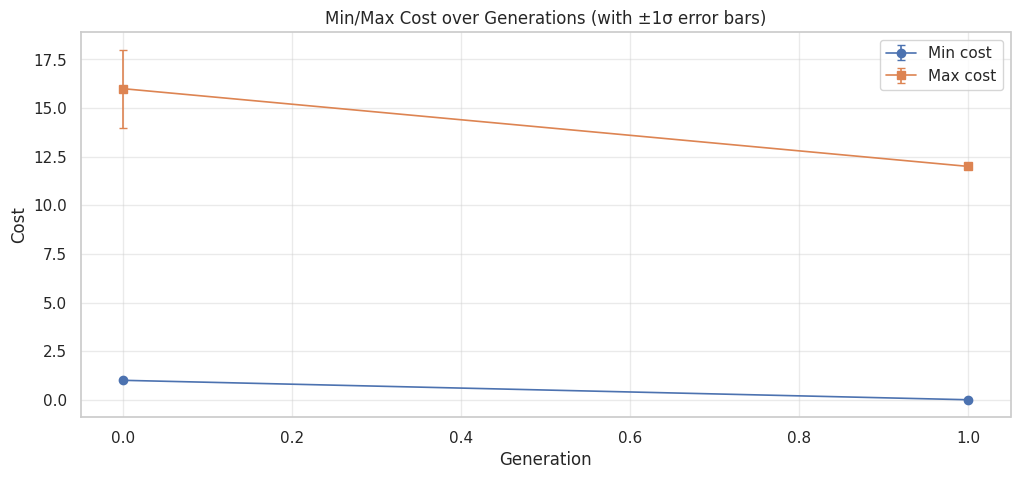

Costs Summary:


,Mean,Std,Min,Max,First,Last
Min cost,0.5,0.5,0,1,1,0
Max cost,14.0,2.0,12,16,16,12


In [ ]:
def plot_generational_fitness(min_weights, max_weights):
    generations = np.arange(len(min_weights))

    # Compute per-series summary stats
    summary = {
        "Mean": [np.mean(min_weights), np.mean(max_weights)],
        "Std":  [np.std(min_weights),  np.std(max_weights)],
        "Min":  [np.min(min_weights),  np.min(max_weights)],
        "Max":  [np.max(min_weights),  np.max(max_weights)],
        "First": [min_weights[0],      max_weights[0]],
        "Last": [min_weights[-1],      max_weights[-1]],
    }
    df = pd.DataFrame(summary, index=["Min cost", "Max cost"])

    error_idx = np.arange(0, len(generations), 2)
    yerr_min = np.zeros_like(min_weights)
    yerr_max = np.zeros_like(max_weights)
    yerr_min[error_idx] = df.loc["Min cost", "Std"]
    yerr_max[error_idx] = df.loc["Max cost", "Std"]

    _, ax = plt.subplots(figsize=(12, 5))
    ax.errorbar(generations, min_weights, yerr=yerr_min, fmt='o-', capsize=3, label="Min cost", lw=1.2)
    ax.errorbar(generations, max_weights, yerr=yerr_max, fmt='s-', capsize=3, label="Max cost", lw=1.2)


    ax.set_xlabel("Generation")
    ax.set_ylabel("Cost")
    ax.set_title("Min/Max Cost over Generations (with ±1σ error bars)")
    ax.grid(True, alpha=0.4)
    ax.legend()

    plt.show()

    print("Costs Summary:")
    pd.set_option("display.precision", 6)
    display(df)
    
plot_generational_fitness(solver.min_weights, solver.max_weights)

# Advanced Implementation

## Optimisation: Permutation Representation State Space Pruning

Considering only a permutation representation of the chess board removes a few orders of magnitude of complexity from the search.

The search algorithm requires some adjustments to crossover and mutation to ensure permutation invariant is not broken, and the way individuals are constructed must change to abide by the invariant.

In [78]:
class PermutationEightQueensGeneticAlgorithm(BaseEightQueensGeneticAlgorithm):
    """
    Permutation state representation genetic algorithm implementation.
    """
    def __init__(self, population, elitism_rate=0.25, mutation_rate=0.25,
                 num_queens=8, early_stopping=False, max_generations=500, seed=1):
        
        self.population = population
        self.elitism_rate = elitism_rate
        self.mutation_rate = mutation_rate
        self.num_queens = num_queens

        self.population_size = len(population)
        self.iterations = 0
        self.start = 0
        self.end = 0
        self.mutation_counter = 0

        self.min_weights = []
        self.max_weights = []

        self.early_stopping = early_stopping
        self.max_generations = max_generations

        self.rng = np.random.default_rng()
        random.seed(seed)
        np.random.seed(seed)
        
    def mutate(self, population):
        """
        Mutation schema that does not break the permutation state representation invariant.
        """
        population2 = []
        for i in range(len(population)):
            if random.random() > self.mutation_rate:
                population2.append(population[i])
                continue
            
            individual = population[i]
            self.mutation_counter += 1
            i, j = self.rng.choice(self.num_queens, size=2, replace=False)
            s = individual.state
            s[i], s[j] = s[j], s[i]
            population2.append(UpdatedEightQueensState(state=s))
        return population2

    def reproduce(self, parent1, parent2):
        """
        Reproduction via order crossover.
        """
        n = self.num_queens
        p1 = parent1.state.copy()
        p2 = parent2.state.copy()

        c1, c2 = sorted(random.sample(range(n), 2))

        middle1 = p1[c1:c2]
        rest1 = [x for x in p2 if x not in middle1]
        child1_state = rest1[:c1] + middle1 + rest1[c1:]

        middle2 = p2[c1:c2]
        rest2 = [x for x in p1 if x not in middle2]
        child2_state = rest2[:c1] + middle2 + rest2[c1:]

        return UpdatedEightQueensState(state=child1_state), UpdatedEightQueensState(state=child2_state)

    @staticmethod
    def build_individual(n):
        individual = random.sample(range(n), n)
        return UpdatedEightQueensState(state=individual)

In [79]:
population_size = 100
num_queens = 8
p = [PermutationEightQueensGeneticAlgorithm.build_individual(num_queens) for _ in range(0, population_size)]
solver = PermutationEightQueensGeneticAlgorithm(population=p, num_queens=num_queens, mutation_rate=0.25, early_stopping=False, seed=1)

solution = solver.solve()

print()
print(f"Took '{solver.get_time_elapsed()}' seconds")
print(f"Number of iterations: '{solver.iterations}'")
print(f"Number of mutations: '{solver.mutation_counter}'")
print(solution.state)


Found solution [5, 2, 4, 6, 0, 3, 1, 7]

Took '0.011118173599243164' seconds
Number of iterations: '2'
Number of mutations: '19'
[5, 2, 4, 6, 0, 3, 1, 7]


## Optimisation: Hyperparameter Tuning

Hyperparameter tuning is conducted in the traditional sense, by varying the hyperparameters of the algorithm and assessing performance. However, there are multiple random components to the genetic algorithm search, and as such, by chance, certain starting populations may benefit certain hyperparameter configurations more than others. In an effort to understand the best configurations irrespective of random starting populations, hyperparameter tuning is executed 10 times using 10 different random seeds. An average of the number of generations taken to find a solution across all tuning iterations is found to determine the best configurations.

In [34]:
pop_sizes = [50, 100, 500]
elitism_rates = [0.05, 0.25, 0.5]
mutation_rates = [0.05, 0.25, 0.5]
seeds = [i for i in range(0, 10)]
num_queens=10

def run_setting(population_size, elitism_rate, mutation_rate, seed=1):
    random.seed(seed)
    np.random.seed(seed)

    population = [PermutationEightQueensGeneticAlgorithm.build_individual(num_queens) for _ in range(population_size)]

    solver = PermutationEightQueensGeneticAlgorithm(
        population=population,
        num_queens=num_queens,
        elitism_rate=elitism_rate,
        mutation_rate=mutation_rate,
        early_stopping=True,
    )

    solution = solver.solve()
    solution_cost = solution.cost()

    return {
        "key": (population_size, elitism_rate, mutation_rate),
        "population_size": population_size,
        "elitism_rate": elitism_rate,
        "mutation_rate": mutation_rate,
        "found_solution": solution_cost == 0,
        "solution_cost": solution_cost,
        "num_generations": solver.iterations,
        "seed": seed,
        "time": solver.get_time_elapsed()
    }

settings = list(itertools.product(pop_sizes, elitism_rates, mutation_rates, seeds))
results = []

with ProcessPoolExecutor(max_workers=12, mp_context=mp.get_context("fork")) as executor:
    futures = []
    for i, (ps, er, mr, seed) in enumerate(settings):
        fut = executor.submit(run_setting, ps, er, mr, seed)
        futures.append(fut)

    for fut in as_completed(futures):
        res = fut.result()
        results.append(res)


Found solution [6, 0, 3, 8, 4, 7, 9, 2, 5, 1]

Found solution [9, 3, 1, 7, 2, 8, 6, 4, 0, 5]

Found solution [6, 2, 5, 1, 9, 0, 8, 4, 7, 3]

Found solution [9, 3, 8, 4, 2, 0, 6, 1, 7, 5]

Found solution [9, 7, 4, 1, 3, 0, 6, 8, 5, 2]

Found solution [6, 8, 3, 0, 4, 9, 1, 5, 7, 2]
Found solution [5, 9, 2, 6, 3, 1, 8, 4, 0, 7]


Found solution [3, 9, 6, 1, 5, 2, 0, 7, 4, 8]

Found solution [4, 7, 1, 8, 5, 2, 0, 3, 6, 9]

Found solution [6, 1, 7, 4, 8, 0, 9, 3, 5, 2]

Found solution [2, 0, 5, 8, 4, 9, 7, 3, 1, 6]

Found solution [4, 9, 3, 0, 2, 8, 6, 1, 7, 5]

Found solution [8, 5, 3, 6, 0, 7, 1, 4, 2, 9]

Found solution [4, 7, 5, 2, 9, 1, 6, 8, 3, 0]

Found solution [0, 5, 9, 2, 6, 8, 3, 1, 4, 7]

Found solution [3, 6, 0, 5, 1, 9, 7, 2, 4, 8]

Found solution [5, 9, 6, 1, 3, 8, 0, 7, 4, 2]

Found solution [4, 0, 8, 3, 5, 7, 9, 1, 6, 2]

Found solution [4, 2, 9, 3, 6, 8, 1, 5, 7, 0]

Found solution [4, 2, 8, 6, 9, 1, 5, 7, 0, 3]

Found solution [5, 8, 2, 0, 3, 7, 9, 1, 6, 4]

Found soluti

The below cell will visualise the top 50 results, ordered by the number of generations taken to arrive at a solution. If more than 500 generations are needed, the search is stopped early.

In [35]:
results_df = pd.DataFrame(results)
summary = (
    results_df
    .groupby(['population_size', 'elitism_rate', 'mutation_rate'], as_index=False)
    .agg(
        runs=('seed', 'count'),
        found_rate=('found_solution', 'mean'),
        mean_cost=('solution_cost', 'mean'),
        std_cost=('solution_cost', 'std'),
        mean_generations=('num_generations', 'mean'),
        std_generations=('num_generations', 'std'),
        mean_time=('time', 'mean'),
        std_time=('time', 'std')))
summary

,population_size,elitism_rate,mutation_rate,runs,found_rate,mean_cost,std_cost,mean_generations,std_generations,mean_time,std_time
0,50,0.05,0.05,10,1.0,0.0,0.000000,92.1,80.912092,0.206481,0.181282
1,50,0.05,0.25,10,1.0,0.0,0.000000,110.0,98.806208,0.254755,0.231653
2,50,0.05,0.50,10,1.0,0.0,0.000000,76.3,64.762901,0.176617,0.149547
3,50,0.25,0.05,10,1.0,0.0,0.000000,143.8,121.463117,0.247816,0.218807
4,50,0.25,0.25,10,1.0,0.0,0.000000,160.2,114.058270,0.280661,0.204235
5,50,0.25,0.50,10,1.0,0.0,0.000000,79.2,64.148785,0.149057,0.123152
6,50,0.50,0.05,10,0.9,0.1,0.316228,267.7,142.866721,0.346419,0.184997
7,50,0.50,0.25,10,1.0,0.0,0.000000,185.3,135.449909,0.231586,0.169459
8,50,0.50,0.50,10,0.9,0.1,0.316228,255.0,138.761986,0.315939,0.167274
9,100,0.05,0.05,10,1.0,0.0,0.000000,54.7,63.494619,0.315057,0.371367


Ordered by mean time, we see there is no obvious correlation between the number of generations taken and the mean time taken.

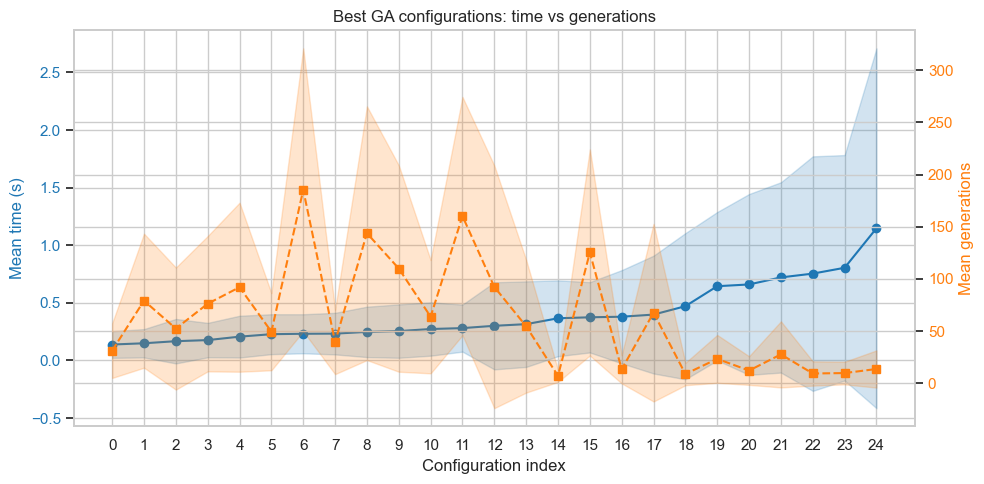

,config_index,population_size,elitism_rate,mutation_rate,mean_time,std_time,mean_generations,std_generations
0,0,100,0.25,0.25,0.138269,0.115764,31.4,26.183965
1,1,50,0.25,0.50,0.149057,0.123152,79.2,64.148785
2,2,100,0.50,0.25,0.167130,0.192994,52.5,58.445131
3,3,50,0.05,0.50,0.176617,0.149547,76.3,64.762901
4,4,50,0.05,0.05,0.206481,0.181282,92.1,80.912092
5,5,100,0.25,0.50,0.227920,0.173280,49.5,36.915068
6,6,50,0.50,0.25,0.231586,0.169459,185.3,135.449909
7,7,100,0.05,0.50,0.232824,0.180403,39.7,30.833063
8,8,50,0.25,0.05,0.247816,0.218807,143.8,121.463117
9,9,50,0.05,0.25,0.254755,0.231653,110.0,98.806208


In [ ]:
sns.set(style="whitegrid")

best = summary[summary["found_rate"] == 1.0].copy()
best = best.sort_values("mean_time").reset_index(drop=True)
best["config_index"] = np.arange(len(best))

x = best["config_index"].values 

fig, ax1 = plt.subplots(figsize=(10, 5))

color_time = "tab:blue"
color_gen = "tab:orange"

# Left y-axis: mean time
ax1.set_xlabel("Configuration index")
ax1.set_ylabel("Mean time (s)", color=color_time)
ax1.plot(x, best["mean_time"], marker="o", linestyle="-", color=color_time, label="Mean time")
ax1.fill_between(
    x,
    best["mean_time"] - best["std_time"],
    best["mean_time"] + best["std_time"],
    alpha=0.2,
    color=color_time,
)
ax1.tick_params(axis="y", labelcolor=color_time)

# Right y-axis: mean generations
ax2 = ax1.twinx()
ax2.set_ylabel("Mean generations", color=color_gen)
ax2.plot(x, best["mean_generations"], marker="s", linestyle="--", color=color_gen, label="Mean generations")
ax2.fill_between(
    x,
    best["mean_generations"] - best["std_generations"],
    best["mean_generations"] + best["std_generations"],
    alpha=0.2,
    color=color_gen,
)
ax2.tick_params(axis="y", labelcolor=color_gen)

ax1.set_xticks(x)
ax1.set_xticklabels(x)

plt.title("Best GA configurations: time vs generations")
fig.tight_layout()
plt.show()

config_df = best[[
    "config_index",
    "population_size",
    "elitism_rate",
    "mutation_rate",
    "mean_time",
    "std_time",
    "mean_generations",
    "std_generations",
]]

display(config_df)


The diversity of results shows that genetic algorithms can have a variety of starting configurations and still identify a global optimal solution. However, this also makes identifying an appropriate configuration before running hyperparameter testing very difficult, as it is not clear which parameters are going to be most important for the specific problem.

### Extension: Empirical Time Complexity Inference

By running the algorithm for n=4 to n=20 and recording the time taken to solve, we infer the time complexity.

In [37]:
pop_sizes = [100]
elitism_rates = [0.05]
mutation_rates = [0.25]
num_queens = [i for i in range(4, 21)]

def run_setting(population_size, elitism_rate, mutation_rate, num_queens, seed=1):
    random.seed(seed)
    np.random.seed(seed)

    population = [PermutationEightQueensGeneticAlgorithm.build_individual(num_queens) for _ in range(population_size)]

    solver = PermutationEightQueensGeneticAlgorithm(
        population=population,
        num_queens=num_queens,
        elitism_rate=elitism_rate,
        mutation_rate=mutation_rate,
        early_stopping=True,
        max_generations=30000
    )

    solution = solver.solve()
    solution_cost = solution.cost()

    return {
        "key": (population_size, elitism_rate, mutation_rate),
        "population_size": population_size,
        "elitism_rate": elitism_rate,
        "mutation_rate": mutation_rate,
        "found_solution": solution_cost == 0,
        "solution_cost": solution_cost,
        "num_generations": solver.iterations,
        "num_queens": num_queens,
        "time": solver.get_time_elapsed()
    }

settings = list(itertools.product(pop_sizes, elitism_rates, mutation_rates, num_queens))
results = []

with ProcessPoolExecutor(max_workers=12, mp_context=mp.get_context("fork")) as executor:
    futures = []
    for i, (ps, er, mr, num_queens) in enumerate(settings):
        fut = executor.submit(run_setting, ps, er, mr, num_queens)
        futures.append(fut)

    for fut in as_completed(futures):
        res = fut.result()
        results.append(res)


Found solution [2, 0, 3, 1]
Found solution [6, 4, 2, 0, 5, 3, 1]
Found solution [2, 0, 3, 1, 4]



Found solution [3, 0, 4, 1, 5, 2]

Found solution [7, 1, 3, 0, 6, 4, 2, 5]

Found solution [2, 6, 1, 7, 5, 3, 0, 4, 8]

Found solution [2, 5, 8, 6, 3, 0, 7, 1, 4, 9]

Found solution [10, 8, 1, 4, 2, 0, 9, 7, 5, 3, 6]

Found solution [12, 5, 2, 8, 10, 3, 9, 6, 1, 11, 0, 7, 4]

Found solution [6, 10, 5, 7, 0, 4, 13, 1, 9, 14, 8, 3, 12, 2, 11]

Found solution [6, 11, 9, 4, 0, 3, 10, 7, 1, 8, 5, 2]

Found solution [9, 1, 4, 13, 10, 12, 5, 3, 11, 6, 8, 2, 0, 7]

Found solution [13, 4, 10, 3, 15, 11, 8, 2, 7, 1, 14, 0, 5, 9, 12, 6]

Found solution [1, 12, 8, 0, 14, 9, 11, 15, 17, 2, 5, 10, 4, 7, 16, 13, 3, 6]

Could not find solution [1, 10, 2, 9, 11, 15, 0, 3, 5, 7, 13, 6, 16, 12, 4, 14, 8]

Could not find solution [9, 6, 0, 3, 17, 13, 18, 8, 11, 7, 4, 15, 1, 10, 16, 14, 12, 5, 2]

Could not find solution [10, 0, 3, 11, 2, 16, 6, 13, 15, 18, 14, 5, 1, 4, 17, 7, 9, 12, 8, 19]


Runtime is plotted against the number of queens to infer time complexity empirically.

In [38]:
df = pd.DataFrame(results)
df

,key,population_size,elitism_rate,mutation_rate,found_solution,solution_cost,num_generations,num_queens,time
0,"(100, 0.05, 0.25)",100,0.05,0.25,True,0,1,4,0.003927
1,"(100, 0.05, 0.25)",100,0.05,0.25,True,0,1,5,0.003970
2,"(100, 0.05, 0.25)",100,0.05,0.25,True,0,1,7,0.003813
3,"(100, 0.05, 0.25)",100,0.05,0.25,True,0,2,6,0.008228
4,"(100, 0.05, 0.25)",100,0.05,0.25,True,0,6,8,0.036073
5,"(100, 0.05, 0.25)",100,0.05,0.25,True,0,7,9,0.038755
6,"(100, 0.05, 0.25)",100,0.05,0.25,True,0,15,10,0.091408
7,"(100, 0.05, 0.25)",100,0.05,0.25,True,0,106,11,0.591384
8,"(100, 0.05, 0.25)",100,0.05,0.25,True,0,338,13,2.059355
9,"(100, 0.05, 0.25)",100,0.05,0.25,True,0,556,15,3.643270


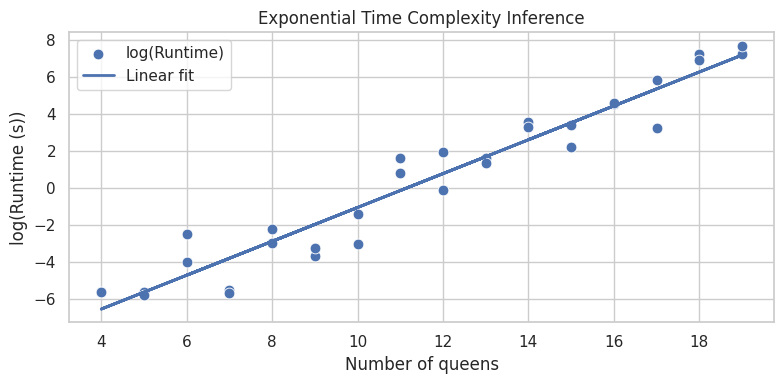

In [81]:
df_fit = df[df["time"] > 0].copy()
x = df_fit["num_queens"].values
y = df_fit["time"].values

log_y = np.log(y)

plt.figure(figsize=(8, 4))
sns.scatterplot(x=x, y=log_y, s=60, label="log(Runtime)")
m, c = np.polyfit(x, log_y, 1)
plt.plot(x, m*x + c, label="Linear fit", linewidth=2)

plt.xlabel("Number of queens")
plt.ylabel("log(Runtime (s))")
plt.title("Exponential Time Complexity Inference")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Extension: Viral Infection

Traditionally, genetic algorithms have more random search components than directed search components. Viral infection has been implemented to bring constraint satisfaction programming ideas into the evolutionary algorithm analogue.

In [ ]:
class ViralInfectionEightQueensGeneticAlgorithm(PermutationEightQueensGeneticAlgorithm):
    """
    Viral infection genetic algorithm implementation.
    """
    def __init__(self, population, elitism_rate=0.25, infection_rate=0.25,
                 num_queens=8, early_stopping=False, max_generations=500):
        
        self.population = population
        self.elitism_rate = elitism_rate
        self.infection_rate = infection_rate
        self.num_queens = num_queens

        self.population_size = len(population)
        self.iterations = 0
        self.start = 0
        self.end = 0
        self.mutation_counter = 0

        self.min_weights = []
        self.max_weights = []

        self.early_stopping = early_stopping
        self.max_generations = max_generations

        self.rng = np.random.default_rng()

        # Initialise viruses (min heap)
        self.viruses = self.get_viruses()

    def solve(self):
        self.start = time.time()
        result = self.search(self.infect)
        self.end = time.time()
        return result

    def infect(self, population):
        """
        Infect a subset of children according to infection_rate.
        Np' = infection_rate * len(population), as in GAVI.
        """
        Np = len(population)
        if Np == 0 or not self.viruses:
            return population

        Np_prime = int(self.infection_rate * Np)
        if Np_prime <= 0:
            return population

        Np_prime = min(Np_prime, len(self.viruses))

        indices = self.rng.choice(Np, size=Np_prime, replace=False)

        for i in indices:
            infectivity, cols, rows = heapq.heappop(self.viruses)

            cost_before = population[i].cost()
            a = population[i].state.copy()
            
            c1, c2 = cols
            r1, r2 = rows
            
            x1 = a.index(r1)
            a[x1], a[c1] = a[c1], r1    
            
            x2 = a.index(r2)
            a[x2], a[c2] = a[c2], r2

            population[i] = UpdatedEightQueensState(state=a)

            cost_after = population[i].cost()

            # Update infectivity (min heap)
            if cost_after < cost_before:
                infectivity *= 2.0
            else:
                infectivity /= 2.0

            infectivity = max(infectivity, -100.0)
            infectivity = min(infectivity, -1e-3)

            heapq.heappush(self.viruses, (infectivity, cols, rows))

        return population
    
    def get_viruses(self):
        """
        Construct initial viruses from the pre-generated self.population.
        Each virus contains:
        - cols = (col_i, col_j)
        - rows = (row_k, row_x)

        Downsample the virus set to keep it proportional to population_size and infection_rate.
        """
        viruses = []
        norm_fitness = self.fitness()
        virus_scores = {}

        centre = (self.num_queens - 1) / 2.0

        for individual, fitness in zip(self.population, norm_fitness):
            state = individual.state 
            for i in range(self.num_queens):
                for j in range(i + 1, self.num_queens):
                    r1 = state[i]
                    r2 = state[j]

                    # Skip invalid row indices
                    if not (0 <= r1 < self.num_queens and 0 <= r2 < self.num_queens):
                        continue

                    # Skip same row (queens attack)
                    if r1 == r2:
                        continue

                    # Skip diagonal conflicts
                    if abs(r1 - r2) == (j - i):
                        continue

                    cols = (i, j)
                    rows = (r1, r2)

                    # Centrality preference
                    dr1 = abs(r1 - centre)
                    dr2 = abs(r2 - centre)
                    dc1 = abs(i - centre)
                    dc2 = abs(j - centre)
                    dist = dr1 + dr2 + dc1 + dc2
                    centre_score = 1.0 / (1.0 + dist)
                    score = fitness * centre_score

                    key = (cols, rows)
                    virus_scores[key] = virus_scores.get(key, 0.0) + score

        for (cols, rows), score in virus_scores.items():
            # Use negative infectivity because of min heap
            infectivity = -score
            viruses.append((infectivity, cols, rows))

        # Downsample virus set
        max_viruses = max(
            self.population_size,
            int(self.population_size * self.infection_rate * 10))
        if len(viruses) > max_viruses:
            idx = self.rng.choice(len(viruses), size=max_viruses, replace=False)
            viruses = [viruses[i] for i in idx]

        heapq.heapify(viruses)
        return viruses

Generated 100 viruses

Found solution [3, 7, 4, 2, 0, 6, 1, 5]

Took '0.024085044860839844' seconds
Number of iterations: '5'
Number of mutations: '0'
[3, 7, 4, 2, 0, 6, 1, 5]


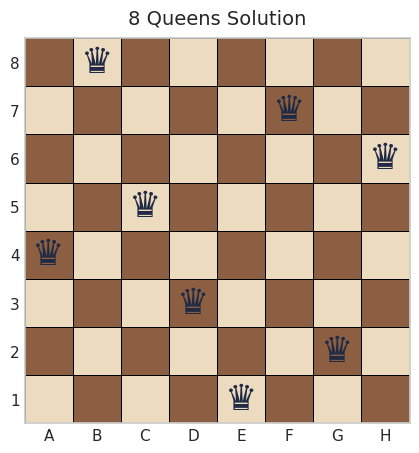

In [85]:
population_size = 100
num_queens = 8
population = [ViralInfectionEightQueensGeneticAlgorithm.build_individual(num_queens) for _ in range(0, population_size)]
solver = ViralInfectionEightQueensGeneticAlgorithm(population=population, num_queens=num_queens, infection_rate=0.1, early_stopping=False)

print(f"Generated {len(solver.viruses)} viruses")

solution = solver.solve()

print()
print(f"Took '{solver.get_time_elapsed()}' seconds")
print(f"Number of iterations: '{solver.iterations}'")
print(f"Number of mutations: '{solver.mutation_counter}'")
print(solution.state)

plot_queens(solution.state, title=f"{num_queens} Queens Solution")

## Extension: n=4 to n=19

The below snippet uses permutation based state representation to calculate a wide range of n-queen problems. Hyperparameters are chosen from the best performners revealed in the previous section: Hyperparameter Tuning.

In [42]:
pop_sizes = [200]
elitism_rates = [0.05]
mmutation_rate = [0.25]
num_queens = [i for i in range(4, 20)]

def run_setting(population_size, elitism_rate, mutation_rate, num_queens):
    random.seed(1)
    np.random.seed(1)

    population = [PermutationEightQueensGeneticAlgorithm.build_individual(num_queens) for _ in range(population_size)]

    solver = PermutationEightQueensGeneticAlgorithm(
        population=population,
        num_queens=num_queens,
        elitism_rate=elitism_rate,
        mutation_rate=mutation_rate,
        early_stopping=False)

    solution = solver.solve()
    
    return {
        "method": "permutation",
        "num_queens": num_queens,
        "solution": solution.state,
        "time": solver.get_time_elapsed()
    }

settings = list(itertools.product(pop_sizes, elitism_rates, mmutation_rate, num_queens))
results = []

with ProcessPoolExecutor(max_workers=12, mp_context=mp.get_context("fork")) as executor:
    futures = []
    for i, (ps, er, mr, nq) in enumerate(settings):
        fut = executor.submit(run_setting, ps, er, mr, nq)
        futures.append(fut)

    for fut in as_completed(futures):
        res = fut.result()
        results.append(res)


Found solution [2, 0, 3, 1]
Found solution [2, 0, 3, 1, 4]
Found solution [6, 4, 2, 0, 5, 3, 1]



Found solution [4, 6, 1, 5, 2, 0, 7, 3, 8]

Found solution [6, 3, 7, 4, 8, 0, 9, 1, 5, 2]

Found solution [0, 5, 7, 2, 6, 3, 1, 4]

Found solution [3, 0, 4, 1, 5, 2]

Found solution [8, 5, 3, 6, 0, 2, 11, 7, 10, 4, 9, 1]

Found solution [4, 0, 7, 5, 10, 8, 1, 3, 9, 6, 2]

Found solution [3, 8, 10, 7, 4, 1, 12, 0, 6, 11, 5, 2, 9]

Found solution [10, 1, 9, 6, 12, 0, 2, 5, 13, 11, 3, 8, 16, 14, 4, 7, 15]

Found solution [8, 3, 12, 4, 13, 1, 5, 14, 11, 6, 0, 2, 10, 7, 9]

Found solution [2, 8, 13, 9, 3, 6, 10, 1, 5, 12, 0, 11, 7, 4]

Found solution [10, 0, 9, 6, 12, 2, 8, 1, 4, 14, 3, 15, 13, 11, 5, 7]

Found solution [9, 3, 13, 7, 10, 17, 1, 4, 18, 12, 15, 5, 11, 6, 14, 16, 8, 0, 2]

Found solution [16, 3, 17, 7, 14, 6, 1, 13, 5, 12, 4, 11, 0, 2, 10, 8, 15, 9]


The below snippet uses viral infection to calculate a wide range of n-queen problems.

In [45]:
pop_sizes = [200]
elitism_rates = [0.05]
infection_rates = [0.25]
num_queens = [i for i in range(4, 20)]

def run_setting(population_size, elitism_rate, infection_rate, num_queens):
    random.seed(1)
    np.random.seed(1)

    population = [ViralInfectionEightQueensGeneticAlgorithm.build_individual(num_queens) for _ in range(population_size)]

    solver = ViralInfectionEightQueensGeneticAlgorithm(
        population=population,
        num_queens=num_queens,
        elitism_rate=elitism_rate,
        infection_rate=infection_rate,
        early_stopping=False)

    solution = solver.solve()
    
    return {
        "method": "viral",
        "num_queens": num_queens,
        "solution": solution.state,
        "time": solver.get_time_elapsed()
    }

settings = list(itertools.product(pop_sizes, elitism_rates, infection_rates, num_queens))

with ProcessPoolExecutor(max_workers=12, mp_context=mp.get_context("fork")) as executor:
    futures = []
    for i, (ps, er, mr, nq) in enumerate(settings):
        fut = executor.submit(run_setting, ps, er, mr, nq)
        futures.append(fut)

    for fut in as_completed(futures):
        res = fut.result()
        results.append(res)


Found solution [2, 0, 3, 1, 4]
Found solution [2, 0, 3, 1]


Found solution [6, 4, 2, 0, 5, 3, 1]

Found solution [4, 2, 0, 5, 3, 1]

Found solution [2, 8, 5, 3, 0, 6, 4, 1, 7]

Found solution [4, 1, 7, 0, 3, 6, 2, 5]

Found solution [4, 0, 7, 3, 6, 8, 1, 5, 9, 2]

Found solution [2, 4, 9, 1, 8, 5, 3, 0, 7, 10, 6]

Found solution [5, 7, 4, 12, 0, 9, 6, 10, 3, 1, 8, 2, 11]

Found solution [1, 6, 2, 9, 11, 0, 5, 3, 10, 7, 4, 8]

Found solution [9, 0, 10, 7, 4, 2, 11, 8, 14, 5, 1, 13, 6, 3, 12]

Found solution [12, 4, 8, 3, 5, 2, 11, 9, 6, 13, 1, 10, 7, 0]

Found solution [4, 9, 14, 8, 13, 0, 2, 7, 15, 6, 12, 10, 1, 11, 5, 3]

Found solution [14, 3, 6, 8, 12, 5, 13, 16, 7, 15, 11, 2, 0, 9, 4, 10, 1]

Found solution [8, 6, 11, 1, 17, 15, 3, 9, 4, 10, 0, 14, 16, 5, 13, 2, 7, 12]

Found solution [11, 8, 3, 16, 10, 5, 9, 15, 17, 14, 7, 1, 4, 0, 18, 13, 2, 12, 6]


The below snippet visualises the difference between the permutation and viral infection implementations.

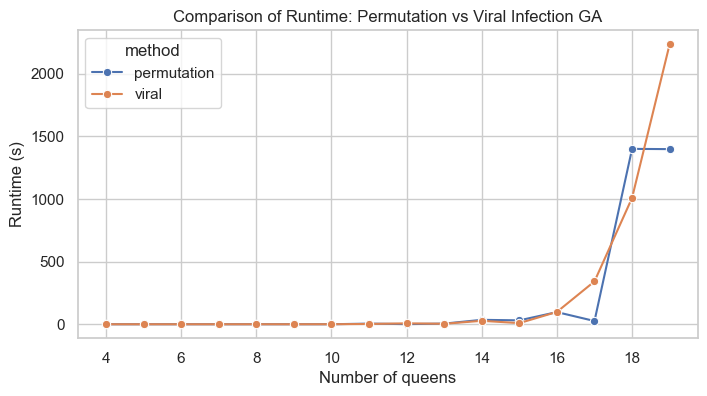

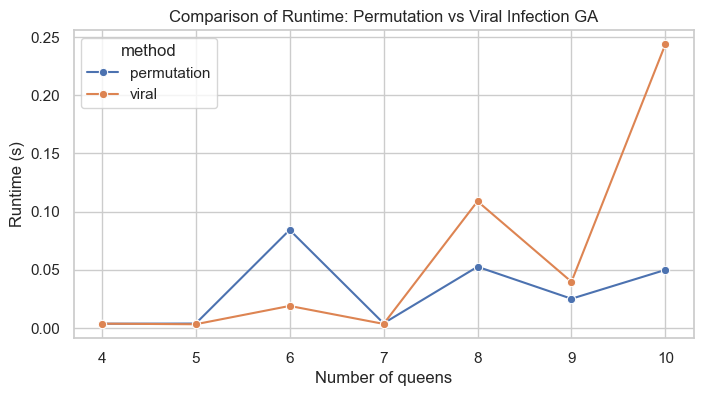

,solution_permutation,solution_viral,time_permutation,time_viral
num_queens,,,,
4,"[2, 0, 3, 1]","[2, 0, 3, 1]",0.003577,0.003630
5,"[2, 0, 3, 1, 4]","[2, 0, 3, 1, 4]",0.003713,0.003116
6,"[3, 0, 4, 1, 5, 2]","[4, 2, 0, 5, 3, 1]",0.084210,0.018865
7,"[6, 4, 2, 0, 5, 3, 1]","[6, 4, 2, 0, 5, 3, 1]",0.003935,0.003411
8,"[0, 5, 7, 2, 6, 3, 1, 4]","[4, 1, 7, 0, 3, 6, 2, 5]",0.052541,0.108830
9,"[4, 6, 1, 5, 2, 0, 7, 3, 8]","[2, 8, 5, 3, 0, 6, 4, 1, 7]",0.025038,0.039620
10,"[6, 3, 7, 4, 8, 0, 9, 1, 5, 2]","[4, 0, 7, 3, 6, 8, 1, 5, 9, 2]",0.049859,0.243850
11,"[4, 0, 7, 5, 10, 8, 1, 3, 9, 6, 2]","[2, 4, 9, 1, 8, 5, 3, 0, 7, 10, 6]",5.068455,2.251474
12,"[8, 5, 3, 6, 0, 2, 11, 7, 10, 4, 9, 1]","[1, 6, 2, 9, 11, 0, 5, 3, 10, 7, 4, 8]",0.923242,7.217210


In [ ]:
df = pd.DataFrame(results)

plt.figure(figsize=(8, 4))
sns.lineplot(data=df, x="num_queens", y="time", hue="method", marker="o")
plt.xlabel("Number of queens")
plt.ylabel("Runtime (s)")
plt.title("Comparison of Runtime: Permutation vs Viral Infection GA")
plt.grid(True)
plt.show()

df_fastest = (
    df.sort_values("num_queens") 
      .groupby("method")
      .head(7)         
      .reset_index(drop=True))
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_fastest, x="num_queens", y="time", hue="method", marker="o")
plt.xlabel("Number of queens")
plt.ylabel("Runtime (s)")
plt.title("Comparison of Runtime: Permutation vs Viral Infection GA")
plt.grid(True)
plt.show()

df_side_by_side = (
    df.set_index(["num_queens", "method"])
      .sort_index()
      .unstack("method"))

df_side_by_side.columns = [f"{col}_{method}" for col, method in df_side_by_side.columns]
df_side_by_side

The below snippet visualises all 16 example n-queen solutions generated by viral infection.

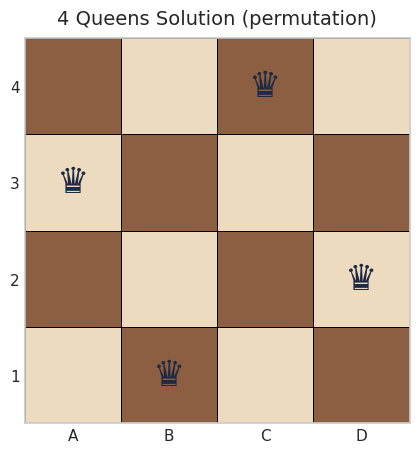

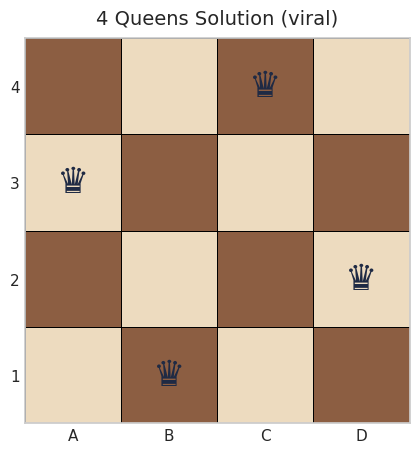

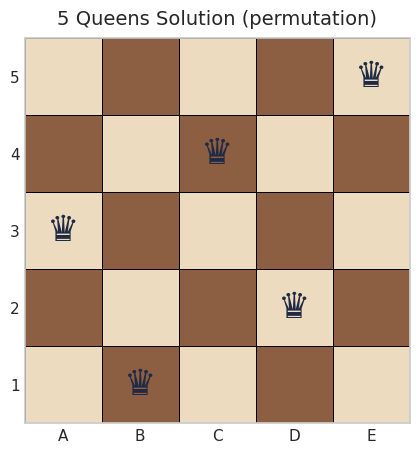

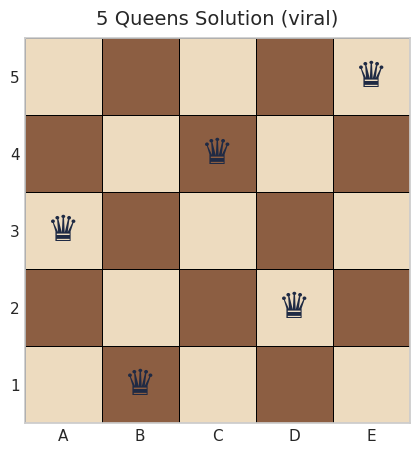

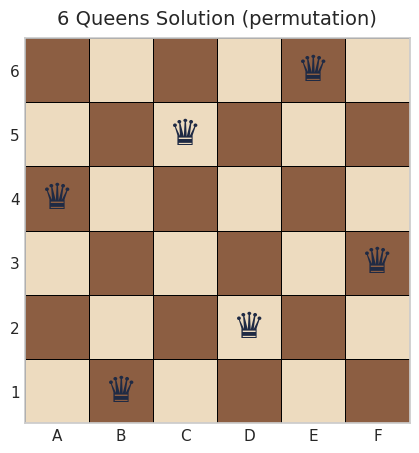

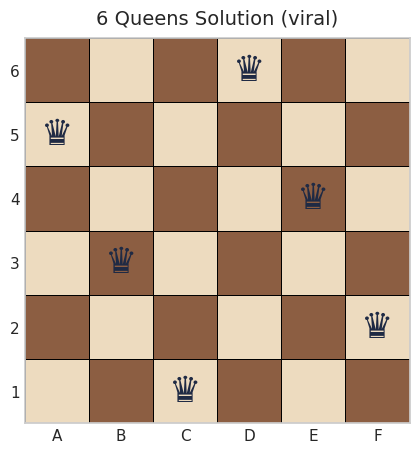

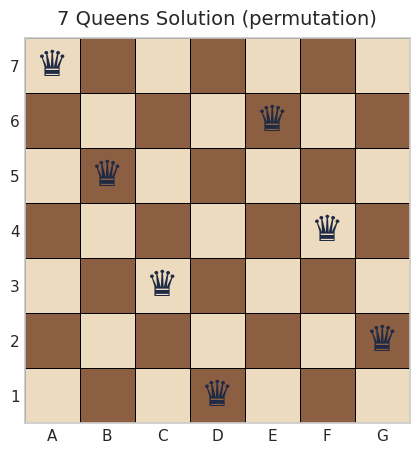

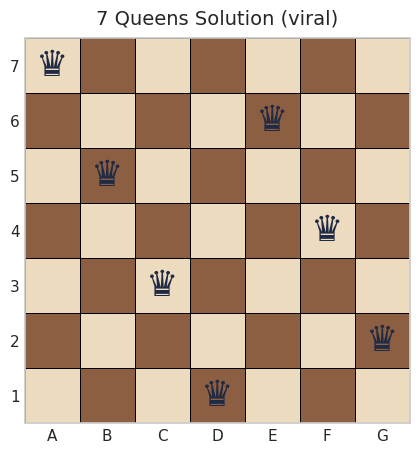

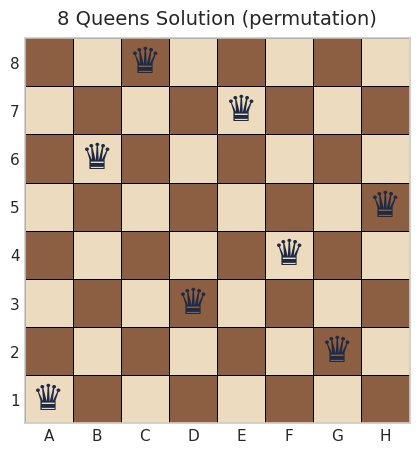

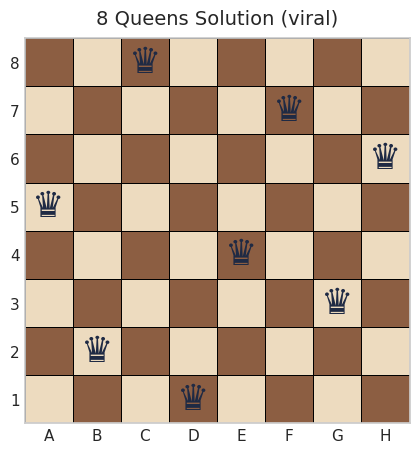

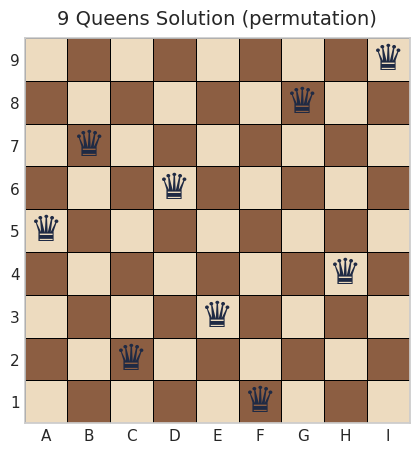

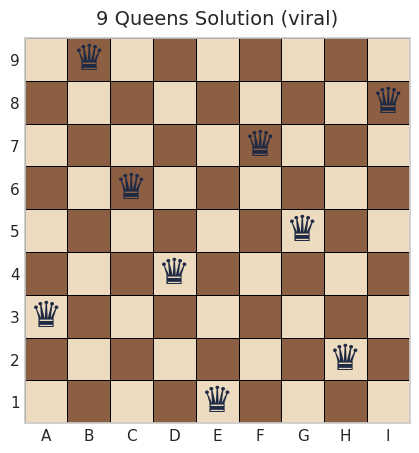

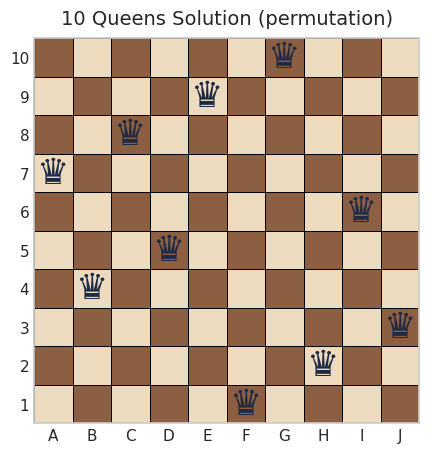

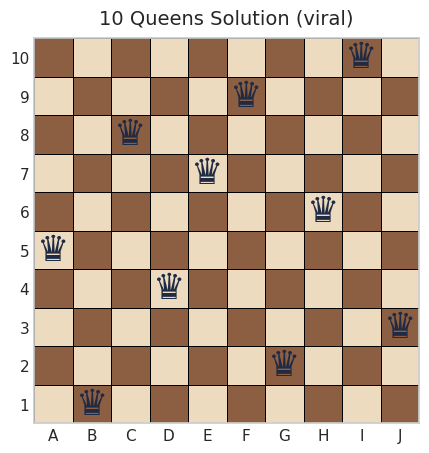

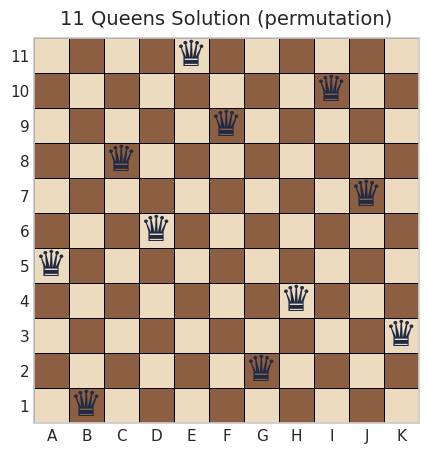

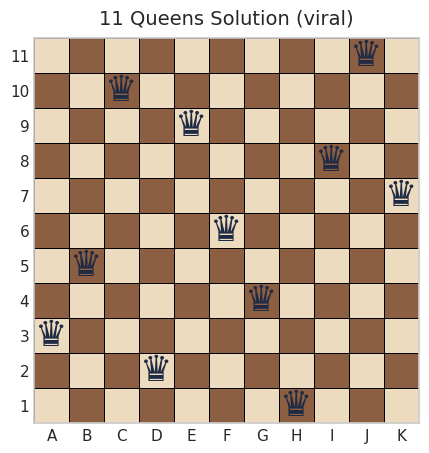

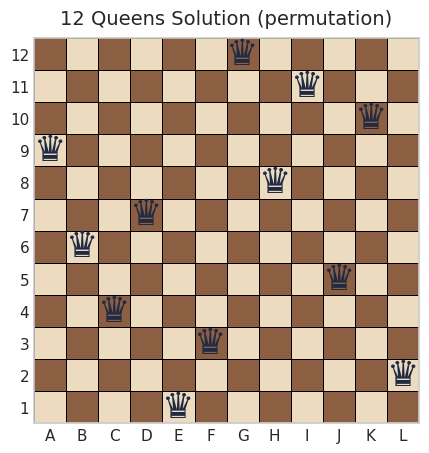

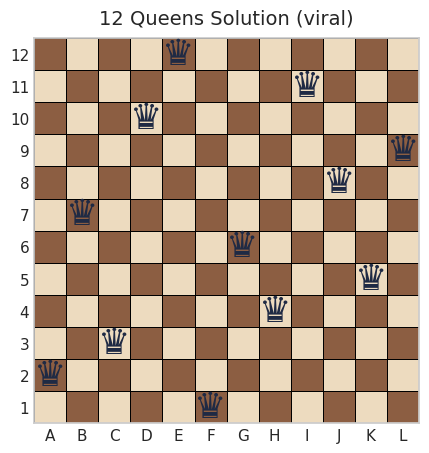

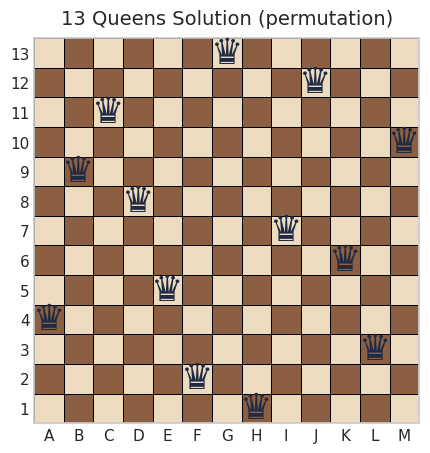

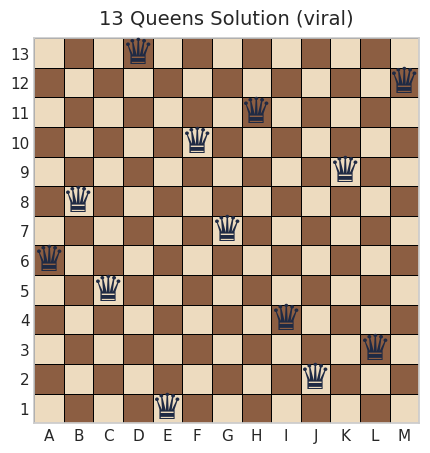

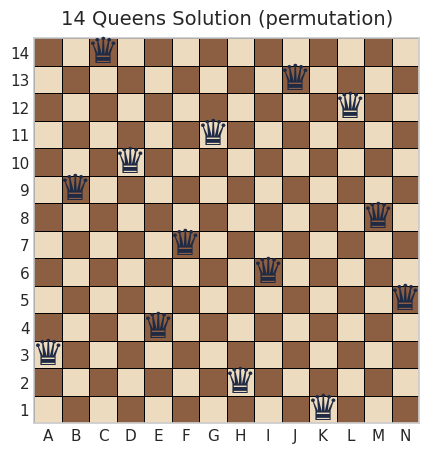

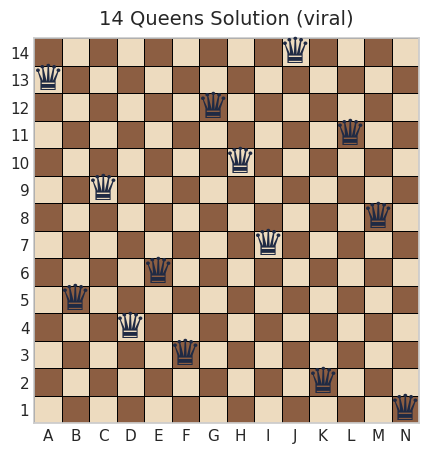

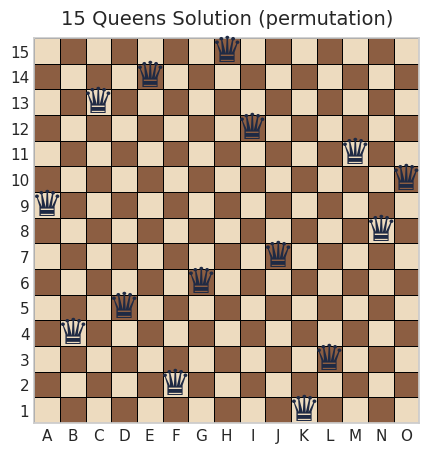

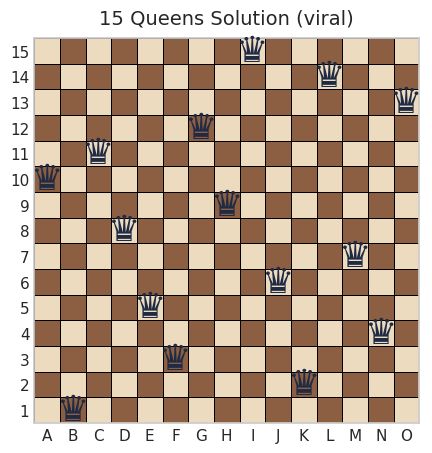

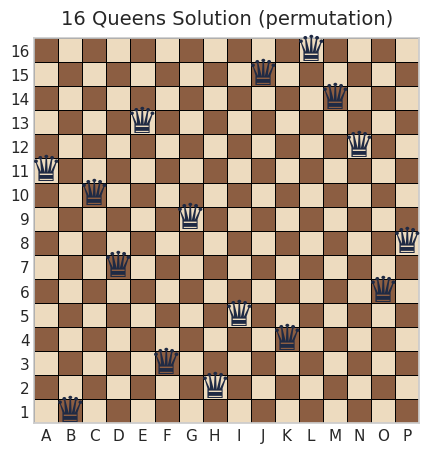

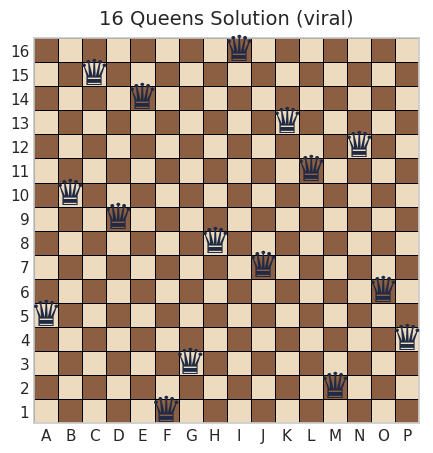

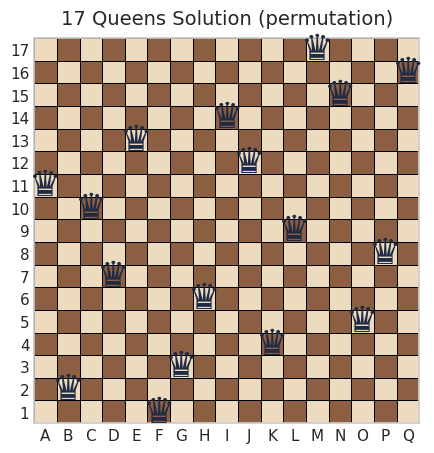

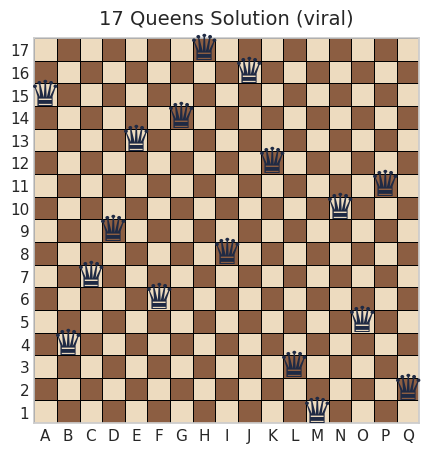

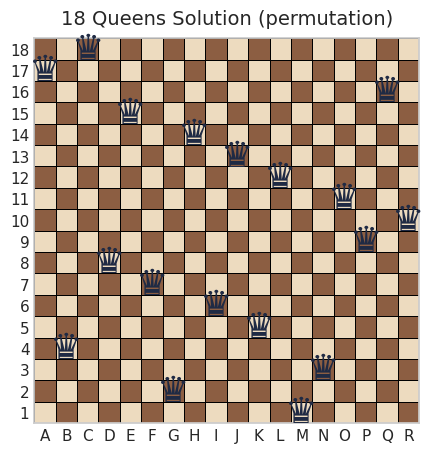

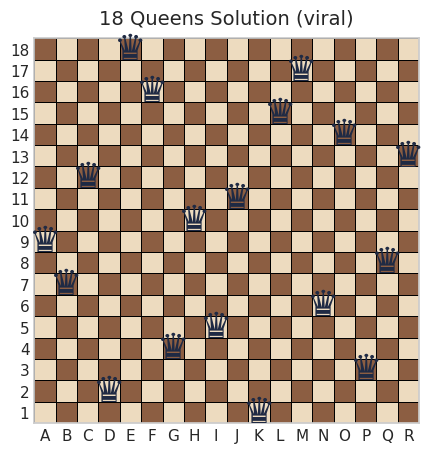

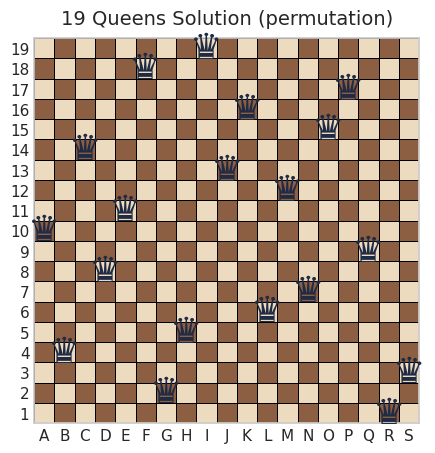

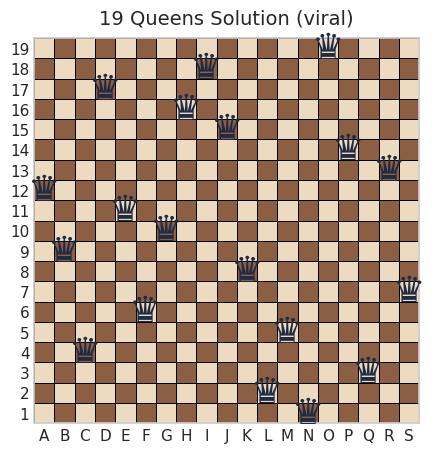

In [86]:
for result in sorted(results, key=lambda r: r["num_queens"]):
    plot_queens(result['solution'], title=f"{result['num_queens']} Queens Solution ({result['method']})")